# Bottleneck Architecture


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

nb_classes = 10
(train_x, train_y), (test_x, test_y) = keras.datasets.cifar10.load_data()
train_x, test_x = train_x / 255.0, test_x / 255.0

train_y = keras.utils.to_categorical(train_y, nb_classes)
test_y = keras.utils.to_categorical(test_y, nb_classes)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


## Basic ResNet

In [ ]:
class ResNetBlock(keras.layers.Layer):
  def __init__(self, f1, f2, s):
    super().__init__()
    kernel_initializer = 'he_normal'
    self.strides = s

    self.residual = keras.Sequential([
      layers.Conv2D(filters=f1, kernel_size=3, strides=s, padding='same', kernel_initializer=kernel_initializer),
      layers.BatchNormalization(),
      layers.ReLU(),
      layers.Conv2D(filters=f2, kernel_size=3, strides=1, padding='same', kernel_initializer=kernel_initializer),
      layers.BatchNormalization(),
    ])

    if s == 2:
      self.shortcut = keras.Sequential([
        layers.Conv2D(filters=f2, kernel_size=1, strides=s, kernel_initializer=kernel_initializer, padding='same'),
        layers.BatchNormalization()
      ])
    else:
      self.shortcut = keras.Sequential([
        layers.Identity()
      ])

  def call(self, inputs):
    shortcut = self.shortcut(inputs)

    x = self.residual(inputs)
    x = layers.add([x, shortcut]) # Or, x = x + shortcut
    x = layers.ReLU()(x) # Or, x = tf.nn.relu(x)

    return x

class ResNet(keras.Model):
  def __init__(self):
    super().__init__()
    self.kernel_initializer = 'he_normal'

  def build(self, input_shape): # automatically called when first __call__ invokes.
    self.first_layer = keras.Sequential([
      layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer=self.kernel_initializer),
      layers.BatchNormalization(),
      layers.ReLU()
    ])

    self.block_layers = []
    filters_per_stage = [64, 128, 256]
    strides_of_first_block_per_stage = [1, 2, 2]
    repeats_per_stage = [3, 3, 3]
    for filters, strides, repeats in zip(filters_per_stage, strides_of_first_block_per_stage, repeats_per_stage):
      for _ in range(repeats):
        self.block_layers.append(ResNetBlock(filters, filters, strides))
        strides = 1

    self.blocks = keras.Sequential(self.block_layers)

    self.last_layer = keras.Sequential([
      layers.GlobalAveragePooling2D(),
      layers.Flatten(),
      layers.Dense(10, kernel_initializer=self.kernel_initializer)
    ])

  def call(self, inputs): # automatically called in __call__ after build().
    x = self.first_layer(inputs)
    x = self.blocks(x)
    x = self.last_layer(x)

    return x

model = ResNet()
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(0.001),
              metrics=['accuracy'])

epoch = 7
batch_size = 128
model.fit(x=train_x, y=train_y, batch_size=batch_size, epochs=epoch, validation_data=(test_x, test_y))

model.summary()

Epoch 1/7
391/391 [==============================] - 30s 44ms/step - loss: 1.2129 - accuracy: 0.5638 - val_loss: 1.7918 - val_accuracy: 0.4999
Epoch 2/7
391/391 [==============================] - 15s 37ms/step - loss: 0.7324 - accuracy: 0.7434 - val_loss: 1.0205 - val_accuracy: 0.6768
Epoch 3/7
391/391 [==============================] - 15s 38ms/step - loss: 0.5503 - accuracy: 0.8091 - val_loss: 0.7825 - val_accuracy: 0.7406
Epoch 4/7
391/391 [==============================] - 15s 37ms/step - loss: 0.4328 - accuracy: 0.8495 - val_loss: 0.9461 - val_accuracy: 0.7149
Epoch 5/7
391/391 [==============================] - 15s 37ms/step - loss: 0.3441 - accuracy: 0.8801 - val_loss: 0.9392 - val_accuracy: 0.7303
Epoch 6/7
391/391 [==============================] - 15s 37ms/step - loss: 0.2703 - accuracy: 0.9051 - val_loss: 0.9376 - val_accuracy: 0.7439
Epoch 7/7
391/391 [==============================] - 15s 37ms/step - loss: 0.2058 - accuracy: 0.9280 - val_loss: 1.3132 - val_accuracy: 0.6887

## Bottleneck ResNet
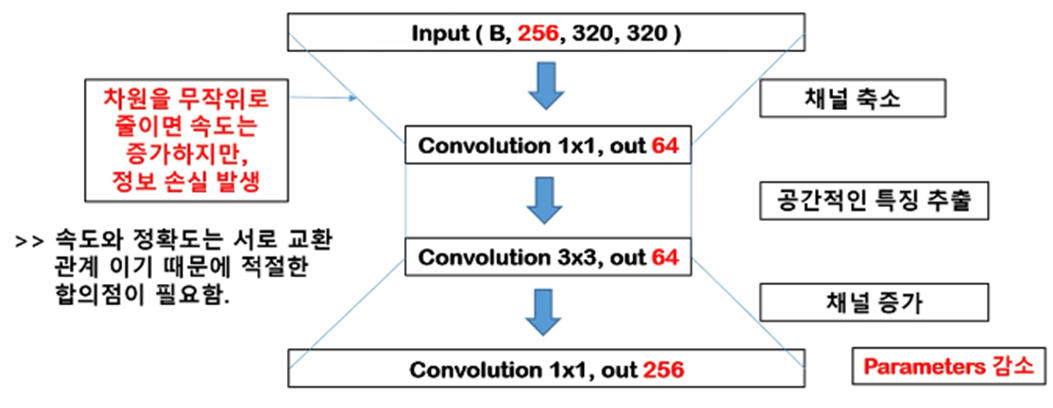

In [2]:
class ResNetBlock(keras.layers.Layer):
  def __init__(self, f1, f2, s):
    super().__init__()
    kernel_initializer = 'he_normal'
    self.strides = s

    self.residual = keras.Sequential([
      # implement bottleneck
      # layers.Conv2D(),
      # layers.BatchNormalization(),
      # layers.ReLU(),
      # layers.Conv2D(),
      # layers.BatchNormalization(),
      # layers.ReLU(),
      # layers.Conv2D(),
      # layers.BatchNormalization(),
      layers.Conv2D(filters = f1/2, kernel_size = 1, strides = s, padding = 'same', kernel_initializer = kernel_initializer),
      layers.BatchNormalization(),
      layers.ReLU(),
      layers.Conv2D(filters = f1/2, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = kernel_initializer),
      layers.BatchNormalization(),
      layers.ReLU(),
      layers.Conv2D(filters = f2, kernel_size = 1, strides = 1, padding = 'same', kernel_initializer = kernel_initializer),
      layers.BatchNormalization(),
    ])

    if s == 2:
      self.shortcut = keras.Sequential([
        layers.Conv2D(filters=f2, kernel_size=3, strides=s, kernel_initializer=kernel_initializer, padding='same'),
        layers.BatchNormalization()
      ])
    else:
      self.shortcut = keras.Sequential([
        layers.Identity()
      ])

  def call(self, inputs):
    shortcut = self.shortcut(inputs)

    x = self.residual(inputs)
    x = layers.add([x, shortcut]) # Or, x = x + shortcut
    x = layers.ReLU()(x) # Or, x = tf.nn.relu(x)

    return x

class ResNet(keras.Model):
  def __init__(self):
    super().__init__()
    self.kernel_initializer = 'he_normal'

  def build(self, input_shape): # automatically called when first __call__ invokes.
    self.first_layer = keras.Sequential([
      layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer=self.kernel_initializer),
      layers.BatchNormalization(),
      layers.ReLU()
    ])

    self.block_layers = []
    filters_per_stage = [64, 128, 256]
    strides_of_first_block_per_stage = [1, 2, 2]
    repeats_per_stage = [3, 3, 3]
    for filters, strides, repeats in zip(filters_per_stage, strides_of_first_block_per_stage, repeats_per_stage):
      for _ in range(repeats):
        self.block_layers.append(ResNetBlock(filters, filters, strides))
        strides = 1

    self.blocks = keras.Sequential(self.block_layers)

    self.last_layer = keras.Sequential([
      layers.GlobalAveragePooling2D(),
      layers.Flatten(),
      layers.Dense(10, kernel_initializer=self.kernel_initializer)
    ])

  def call(self, inputs): # automatically called in __call__ after build().
    x = self.first_layer(inputs)

    x = self.blocks(x)
    x = self.last_layer(x)

    return x

model = ResNet()
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(0.001),
              metrics=['accuracy'])

epoch = 7
batch_size = 128
model.fit(x=train_x, y=train_y, batch_size=batch_size, epochs=epoch, validation_data=(test_x, test_y))

model.summary()

Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:1387: UserWarning: Layer 'res_net_block' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''Cannot convert '(1, 1, 64, 32.0)' to a shape. Found invalid entry '32.0' of type '<class 'float'>'. ''
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'res_net_block', however the layer does not have a `build()` method implem

ValueError: Exception encountered when calling ResNetBlock.call().

[1mCould not automatically infer the output shape / dtype of 'res_net_block' (of type ResNetBlock). Either the `ResNetBlock.call()` method is incorrect, or you need to implement the `ResNetBlock.compute_output_spec() / compute_output_shape()` method. Error encountered:

Cannot convert '(1, 1, 64, 32.0)' to a shape. Found invalid entry '32.0' of type '<class 'float'>'. [0m

Arguments received by ResNetBlock.call():
  • args=('<KerasTensor shape=(None, 32, 32, 64), dtype=float32, sparse=False, name=keras_tensor_4>',)
  • kwargs=<class 'inspect._empty'>

## Depthwise Separable Convolution ResNet

In [ ]:
class ResNetBlock(keras.layers.Layer):
  def __init__(self, f1, f2, s):
    super().__init__()
    kernel_initializer = 'he_normal'
    self.strides = s

    self.residual = keras.Sequential([
      # implement depthwise separable
      # layers.DepthwiseConv2D(),
      # layers.Conv2D(),
      # layers.BatchNormalization(),
      # layers.ReLU(),
      # layers.DepthwiseConv2D(),
      # layers.Conv2D(),
      # layers.BatchNormalization(),
    ])

    if s == 2:
      self.shortcut = keras.Sequential([
        layers.Conv2D(filters=f2, kernel_size=3, strides=s, kernel_initializer=kernel_initializer, padding='same'),
        layers.BatchNormalization()
      ])
    else:
      self.shortcut = keras.Sequential([
        layers.Identity()
      ])

  def call(self, inputs):
    shortcut = self.shortcut(inputs)

    x = self.residual(inputs)
    x = layers.add([x, shortcut]) # Or, x = x + shortcut
    x = layers.ReLU()(x) # Or, x = tf.nn.relu(x)

    return x

class ResNet(keras.Model):
  def __init__(self):
    super().__init__()
    self.kernel_initializer = 'he_normal'

  def build(self, input_shape): # automatically called when first __call__ invokes.
    self.first_layer = keras.Sequential([
      layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer=self.kernel_initializer),
      layers.BatchNormalization(),
      layers.ReLU()
    ])

    self.block_layers = []
    filters_per_stage = [64, 128, 256]
    strides_of_first_block_per_stage = [1, 2, 2]
    repeats_per_stage = [3, 3, 3]
    for filters, strides, repeats in zip(filters_per_stage, strides_of_first_block_per_stage, repeats_per_stage):
      for _ in range(repeats):
        self.block_layers.append(ResNetBlock(filters, filters, strides))
        strides = 1

    self.blocks = keras.Sequential(self.block_layers)

    self.last_layer = keras.Sequential([
      layers.GlobalAveragePooling2D(),
      layers.Flatten(),
      layers.Dense(10, kernel_initializer=self.kernel_initializer)
    ])

  def call(self, inputs): # automatically called in __call__ after build().
    x = self.first_layer(inputs)

    x = self.blocks(x)
    x = self.last_layer(x)

    return x

model = ResNet()
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(0.001),
              metrics=['accuracy'])

epoch = 7
batch_size = 128
model.fit(x=train_x, y=train_y, batch_size=batch_size, epochs=epoch, validation_data=(test_x, test_y))

model.summary()

Epoch 1/7
391/391 [==============================] - 29s 38ms/step - loss: 1.2645 - accuracy: 0.5413 - val_loss: 2.5119 - val_accuracy: 0.2523
Epoch 2/7
391/391 [==============================] - 14s 35ms/step - loss: 0.8089 - accuracy: 0.7139 - val_loss: 1.2206 - val_accuracy: 0.6035
Epoch 3/7
391/391 [==============================] - 14s 35ms/step - loss: 0.6128 - accuracy: 0.7848 - val_loss: 1.0206 - val_accuracy: 0.6903
Epoch 4/7
391/391 [==============================] - 14s 35ms/step - loss: 0.4841 - accuracy: 0.8304 - val_loss: 1.0513 - val_accuracy: 0.6882
Epoch 5/7
391/391 [==============================] - 14s 35ms/step - loss: 0.3923 - accuracy: 0.8638 - val_loss: 0.8661 - val_accuracy: 0.7294
Epoch 6/7
391/391 [==============================] - 14s 35ms/step - loss: 0.3047 - accuracy: 0.8943 - val_loss: 1.1781 - val_accuracy: 0.6726
Epoch 7/7
391/391 [==============================] - 14s 35ms/step - loss: 0.2282 - accuracy: 0.9200 - val_loss: 1.2637 - val_accuracy: 0.7123

## Your Own ResNet

In [ ]:
class ResNetBlock(keras.layers.Layer):
  def __init__(self, f1, f2, s):
    super().__init__()
    kernel_initializer = 'he_normal'
    self.strides = s

    self.residual = keras.Sequential([
      # implement your own resnet
    ])

    if s == 2:
      self.shortcut = keras.Sequential([
        layers.Conv2D(filters=f2, kernel_size=3, strides=s, kernel_initializer=kernel_initializer, padding='same'),
        layers.BatchNormalization()
      ])
    else:
      self.shortcut = keras.Sequential([
        layers.Identity()
      ])

  def call(self, inputs):
    shortcut = self.shortcut(inputs)

    x = self.residual(inputs)
    x = layers.add([x, shortcut]) # Or, x = x + shortcut
    x = layers.ReLU()(x) # Or, x = tf.nn.relu(x)

    return x

class ResNet(keras.Model):
  def __init__(self):
    super().__init__()
    self.kernel_initializer = 'he_normal'

  def build(self, input_shape): # automatically called when first __call__ invokes.
    self.first_layer = keras.Sequential([
      layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer=self.kernel_initializer),
      layers.BatchNormalization(),
      layers.ReLU()
    ])

    self.blocks = []
    filters_per_stage = [64, 128, 256]
    strides_of_first_block_per_stage = [1, 2, 2]
    repeats_per_stage = [3, 3, 3]
    for filters, strides, repeats in zip(filters_per_stage, strides_of_first_block_per_stage, repeats_per_stage):
      for _ in range(repeats):
        self.blocks.append(ResNetBlock(filters, filters, strides))
        strides = 1

    self.last_layer = keras.Sequential([
      layers.GlobalAveragePooling2D(),
      layers.Flatten(),
      layers.Dense(10, kernel_initializer=self.kernel_initializer)
    ])

  def call(self, inputs): # automatically called in __call__ after build().
    x = self.first_layer(inputs)

    x = self.blocks(x)
    x = self.last_layer(x)

    return x

model = ResNet()
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(0.001),
              metrics=['accuracy'])

epoch = 7
batch_size = 128
model.fit(x=train_x, y=train_y, batch_size=batch_size, epochs=epoch, validation_data=(test_x, test_y))

model.summary()

Epoch 1/7
391/391 [==============================] - 31s 36ms/step - loss: 1.4209 - accuracy: 0.4821 - val_loss: 2.3986 - val_accuracy: 0.2838
Epoch 2/7
391/391 [==============================] - 13s 34ms/step - loss: 0.9820 - accuracy: 0.6485 - val_loss: 1.4085 - val_accuracy: 0.5460
Epoch 3/7
391/391 [==============================] - 13s 34ms/step - loss: 0.7897 - accuracy: 0.7196 - val_loss: 1.2317 - val_accuracy: 0.6090
Epoch 4/7
391/391 [==============================] - 13s 34ms/step - loss: 0.6550 - accuracy: 0.7706 - val_loss: 1.0816 - val_accuracy: 0.6453
Epoch 5/7
391/391 [==============================] - 13s 34ms/step - loss: 0.5550 - accuracy: 0.8069 - val_loss: 1.0239 - val_accuracy: 0.6807
Epoch 6/7
391/391 [==============================] - 13s 34ms/step - loss: 0.4655 - accuracy: 0.8367 - val_loss: 1.1728 - val_accuracy: 0.6429
Epoch 7/7
391/391 [==============================] - 13s 34ms/step - loss: 0.3930 - accuracy: 0.8619 - val_loss: 0.9987 - val_accuracy: 0.6989